# TROPOMI S5P CH4 Level 2 - Single File Processing and Visualization

## About

This notebook demonstrates loading data from a single TROPOMI S5P Level 2 CH4 (NetCDF4/HDF5) file. It performs the following:
1. Extracts latitude, longitude, UTC time, QA value, and methane data (e.g., methane_mixing_ratio_bias_corrected) from the `/PRODUCT` group.
2. Filters the data for `qa_value > 0.5` (or other recommended threshold).
3. Visualizes a map of the filtered methane data.
4. Saves the extracted and filtered pixel data to an ASCII (CSV) file.

## Step 1: Load Python Libraries

In [1]:
import xarray as xr 
import numpy as np      
import os                    
import datetime              

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Step 2: User Settings and File Path

In [2]:
# --- User Settings --- #
# *** DEFINE THE FULL PATH TO YOUR SINGLE TROPOMI CH4 FILE HERE ***
tropomi_ch4_file_path = '../data/tropomi_ch4/S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422.nc' # Example path - REPLACE WITH YOUR FILE

output_image_dir = '../output/images/' 
output_ascii_dir = '../output/ascii/'   

# Variable paths within the NetCDF file (typically under /PRODUCT group for TROPOMI L2 CH4)
lat_var_path = '/PRODUCT/latitude'
lon_var_path = '/PRODUCT/longitude'
ch4_var_path = '/PRODUCT/methane_mixing_ratio_bias_corrected' # Or 'methane_mixing_ratio'
qa_var_path = '/PRODUCT/qa_value'
time_utc_var_path = '/PRODUCT/time_utc' # This is 1D (scanline) in PRODUCT group for CH4
# --- End User Settings --- #

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_ascii_dir, exist_ok=True)

data_loaded_successfully = False
base_filename_for_output = "TROPOMI_CH4_Single_NoData"
if not os.path.exists(tropomi_ch4_file_path):
    print(f"Error: File not found at {tropomi_ch4_file_path}")
else:
    print(f"Processing file: {tropomi_ch4_file_path}")
    data_loaded_successfully = True 
    base_filename_for_output = os.path.splitext(os.path.basename(tropomi_ch4_file_path))[0]

Processing file: ../data/tropomi_ch4/S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422.nc


## Step 3: Load Data using `xarray`, Process, and Prepare for Plotting/Saving

In [3]:
latitude_granule_for_plot = None 
longitude_granule_for_plot = None 
ch4_qa_filtered_granule = None 

ascii_pixels_datetime = []
ascii_pixels_lat = []
ascii_pixels_lon = []
ascii_pixels_ch4 = []
ascii_pixels_qa = []

var_attributes = {}
map_extent_calculated = False
global_lat_min, global_lat_max, global_lon_min, global_lon_max = None, None, None, None

if data_loaded_successfully: 
    ds_product = None # Initialize ds_product to None
    try:
        ds_product = xr.open_dataset(tropomi_ch4_file_path, engine='h5netcdf', group='PRODUCT')
        print(f"  Successfully opened file and accessed /PRODUCT group: {os.path.basename(tropomi_ch4_file_path)}")
        
        # Extract data directly from xarray dataset 
        # TROPOMI L2 products usually have a 'time' dimension of size 1 for the main data variables
        latitude_granule_raw = ds_product['latitude'].data[0,:,:] 
        longitude_granule_raw = ds_product['longitude'].data[0,:,:]
        ch4_raw_granule = ds_product['methane_mixing_ratio_bias_corrected'].data[0,:,:] # Adjust if using 'methane_mixing_ratio'
        qa_raw_granule = ds_product['qa_value'].data[0,:,:]
        time_utc_raw_1d = ds_product['time_utc'].data[0,:] # This is 1D (scanline)

        # Get attributes
        var_attributes['CH4_long_name'] = ds_product['methane_mixing_ratio_bias_corrected'].attrs.get('long_name', 'Methane Mixing Ratio')
        var_attributes['CH4_units'] = ds_product['methane_mixing_ratio_bias_corrected'].attrs.get('units', 'ppb')
        var_attributes['CH4_fill_value'] = ds_product['methane_mixing_ratio_bias_corrected'].attrs.get('_FillValue', np.nan) 
        var_attributes['QA_fill_value'] = ds_product['qa_value'].attrs.get('_FillValue', 255) 
        var_attributes['QA_scale_factor'] = ds_product['qa_value'].attrs.get('scale_factor', 1.0)
        var_attributes['QA_add_offset'] = ds_product['qa_value'].attrs.get('add_offset', 0.0)
        var_attributes['Lat_fill_value'] = ds_product['latitude'].attrs.get('_FillValue', np.nan)
        var_attributes['Lon_fill_value'] = ds_product['longitude'].attrs.get('_FillValue', np.nan)

        qa_fill_val = var_attributes['QA_fill_value']
        qa_processed_granule = np.where(qa_raw_granule == qa_fill_val, np.nan, qa_raw_granule.astype(float) * var_attributes['QA_scale_factor'] + var_attributes['QA_add_offset'])

        ch4_fill_val = var_attributes['CH4_fill_value']
        ch4_processed_granule = np.where(ch4_raw_granule == ch4_fill_val, np.nan, ch4_raw_granule) 
        
        # Apply QA filter (typically > 0.5 for TROPOMI, verify for CH4 product)
        ch4_qa_filtered_granule = np.where(qa_processed_granule > 0.5, ch4_processed_granule, np.nan)

        latitude_granule_for_plot = np.where(latitude_granule_raw == var_attributes['Lat_fill_value'], np.nan, latitude_granule_raw)
        longitude_granule_for_plot = np.where(longitude_granule_raw == var_attributes['Lon_fill_value'], np.nan, longitude_granule_raw)

        valid_lons = longitude_granule_for_plot[~np.isnan(longitude_granule_for_plot)]
        valid_lats = latitude_granule_for_plot[~np.isnan(latitude_granule_for_plot)]
        if valid_lons.size > 0 and valid_lats.size > 0:
            global_lon_min, global_lon_max = np.nanmin(valid_lons), np.nanmax(valid_lons)
            global_lat_min, global_lat_max = np.nanmin(valid_lats), np.nanmax(valid_lats)
            map_extent_calculated = True
            print("Map extent calculated:")
            print(f"  Longitude: {global_lon_min:.2f} to {global_lon_max:.2f}")
            print(f"  Latitude:  {global_lat_min:.2f} to {global_lat_max:.2f}")
        else:
            print("Warning: No valid longitude/latitude data for extent.")
            data_loaded_successfully = False 

        # Expand 1D time_utc to 2D pixel level
        time_utc_pixel_granule = np.empty_like(latitude_granule_raw, dtype=object)
        for i_scanline in range(latitude_granule_raw.shape[0]): # scanline dimension
            time_utc_pixel_granule[i_scanline, :] = time_utc_raw_1d[i_scanline]

        # Iterate and collect valid pixels for ASCII
        for y_idx in range(latitude_granule_for_plot.shape[0]):
            for x_idx in range(latitude_granule_for_plot.shape[1]):
                current_ch4_val = ch4_qa_filtered_granule[y_idx, x_idx]
                current_qa_val = qa_processed_granule[y_idx, x_idx]
                current_lat_val = latitude_granule_for_plot[y_idx, x_idx]
                current_lon_val = longitude_granule_for_plot[y_idx, x_idx]
                current_time_str = time_utc_pixel_granule[y_idx, x_idx]
                
                if not np.isnan(current_ch4_val) and not np.isnan(current_lat_val) and not np.isnan(current_lon_val):
                    try:
                        dt_obj = datetime.datetime.strptime(current_time_str.decode('utf-8') if isinstance(current_time_str, bytes) else current_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
                        dt_obj = dt_obj.replace(tzinfo=datetime.timezone.utc)
                    except ValueError:
                        dt_obj = None 
                    
                    if dt_obj is not None:
                        ascii_pixels_datetime.append(dt_obj)
                        ascii_pixels_lat.append(current_lat_val)
                        ascii_pixels_lon.append(current_lon_val)
                        ascii_pixels_ch4.append(current_ch4_val)
                        ascii_pixels_qa.append(current_qa_val if not np.isnan(current_qa_val) else -1.0)
        
        print(f"\nSuccessfully processed data from {tropomi_ch4_file_path}")

    except Exception as e:
        print(f"Error processing file {tropomi_ch4_file_path}: {e}")
        data_loaded_successfully = False
    finally:
        if ds_product: # Check if ds_product was successfully assigned
            ds_product.close()
            print(f"  NetCDF file {os.path.basename(tropomi_ch4_file_path)} has been closed.")
else:
    print("File path was not valid initially or file not found. Nothing to process.")

print("Data loading and processing complete.")

  Successfully opened file and accessed /PRODUCT group: S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422.nc
Map extent calculated:
  Longitude: -180.00 to 180.00
  Latitude:  -89.96 to 89.95

Successfully processed data from ../data/tropomi_ch4/S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422.nc
  NetCDF file S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422.nc has been closed.
Data loading and processing complete.


## Step 4: Visualize and Save Methane Map
Methane data is filtered where `qa_value > 0.5`.

Methane Map saved to: ../output/images/S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422_CH4_QA05.png


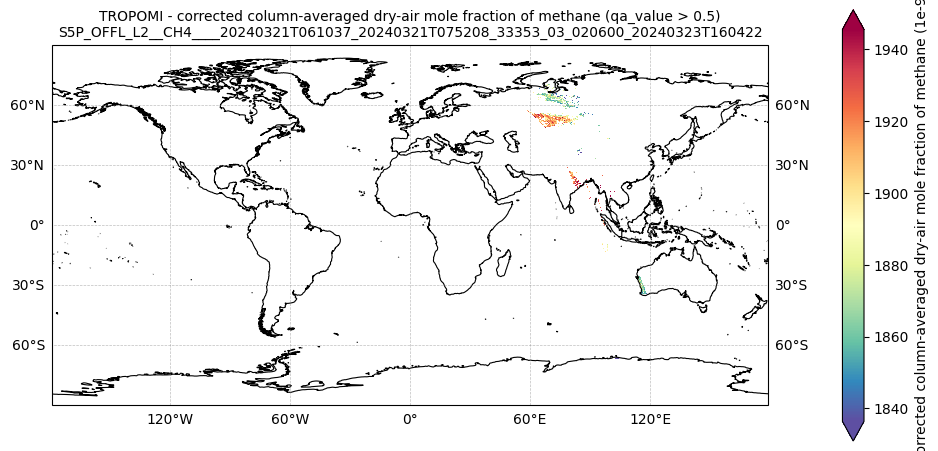

In [4]:
if data_loaded_successfully and map_extent_calculated and latitude_granule_for_plot is not None and ch4_qa_filtered_granule is not None:
    extent_padding_val = 1.0 
    map_extent_plot = [global_lon_min - extent_padding_val, global_lon_max + extent_padding_val, 
                       global_lat_min - extent_padding_val, global_lat_max + extent_padding_val]

    fig = plt.figure(figsize=(12, 8)) 
    ax = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax.set_extent(map_extent_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_plot}: {e}. Using global extent.")
        ax.set_global()
    
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = True 
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plotted_mesh_ch4 = None 
    ch4_to_plot = ch4_qa_filtered_granule 

    valid_ch4_data = ch4_to_plot[~np.isnan(ch4_to_plot)]
    if valid_ch4_data.size > 0:
        # Dynamic range for CH4 (ppb), adjust as needed or use fixed typical values
        vmin_plot = np.percentile(valid_ch4_data, 2)  # e.g., 2nd percentile
        vmax_plot = np.percentile(valid_ch4_data, 98) # e.g., 98th percentile
        # Typical CH4 background is ~1800-1900 ppb. Adjust if needed.
        # vmin_plot = 1700 
        # vmax_plot = 2200
        if vmax_plot <= vmin_plot: vmax_plot = vmin_plot + 50 # Ensure a valid range
    else:
        vmin_plot = 1700 # Default if no valid data
        vmax_plot = 2200 

    if ch4_to_plot.size > 0 and np.any(~np.isnan(ch4_to_plot)):
        mesh = ax.pcolormesh(longitude_granule_for_plot, latitude_granule_for_plot, ch4_to_plot, 
                             transform=ccrs.PlateCarree(), 
                             cmap='Spectral_r', # Or 'viridis', 'plasma', 'jet'
                             vmin=vmin_plot, 
                             vmax=vmax_plot, 
                             shading='auto')
        plotted_mesh_ch4 = mesh
    
    ch4_display_long_name = var_attributes.get('CH4_long_name', 'Methane')
    ch4_display_units = var_attributes.get('CH4_units', 'ppb')
    title_str_prefix = f'TROPOMI - {ch4_display_long_name} (qa_value > 0.5)'
    title_str_suffix = base_filename_for_output

    if plotted_mesh_ch4 is not None:
        cbar = plt.colorbar(plotted_mesh_ch4, ax=ax, orientation='vertical', pad=0.08, shrink=0.7, extend='both')
        cbar.set_label(f"{ch4_display_long_name} ({ch4_display_units})")
        plt.title(f'{title_str_prefix}\n{title_str_suffix}', fontsize=10)
    else:
        print("No valid CH4 data to plot for this file after QA filtering.")
        plt.title(f'{title_str_prefix}\nNo valid data in {title_str_suffix}', fontsize=10)
    
    save_filename_ch4 = f"{base_filename_for_output}_CH4_QA05.png"
    full_save_path_ch4 = os.path.join(output_image_dir, save_filename_ch4)
    plt.savefig(full_save_path_ch4, dpi=300, bbox_inches='tight') 
    print(f"Methane Map saved to: {full_save_path_ch4}")
    plt.show() 
    plt.close(fig)
else:
    print("Skipping CH4 map plotting: Data not loaded, map extent not calculated, or no plottable CH4 data.")

## Step 5: Save Extracted Data to ASCII (CSV) File
Saves datetime, latitude, longitude, QA-filtered methane data, and the QA value itself for all valid pixels from the single file.

In [5]:
if data_loaded_successfully and ascii_pixels_datetime:
    ascii_filename = f"{base_filename_for_output}_pixel_data.csv"
    full_ascii_path = os.path.join(output_ascii_dir, ascii_filename)

    ch4_units_for_header = var_attributes.get('CH4_units', 'ppb').replace(" ", "_")
    print(f"\nSaving valid pixel data to ASCII file: {full_ascii_path}")
    with open(full_ascii_path, 'w') as f:
        f.write(f"Datetime_UTC,Latitude,Longitude,CH4_{ch4_units_for_header}_QA05,QA_Value\n")
        
        for i in range(len(ascii_pixels_datetime)):
            dt_obj = ascii_pixels_datetime[i]
            lat_val = ascii_pixels_lat[i]
            lon_val = ascii_pixels_lon[i]
            ch4_val = ascii_pixels_ch4[i]
            qa_val = ascii_pixels_qa[i]
            
            dt_str = dt_obj.strftime('%Y-%m-%dT%H:%M:%S.%fZ') 
            ch4_format = ".2f" if ch4_units_for_header.lower() == 'ppb' else ".4e"
            f.write(f"{dt_str},{lat_val:.4f},{lon_val:.4f},{ch4_val:{ch4_format}},{qa_val:.2f}\n") 
            
        print(f"Finished writing ASCII file. {len(ascii_pixels_datetime)} valid data points written.")
else:
    print("Skipping ASCII file generation: No valid data points were processed or data loading failed.")


Saving valid pixel data to ASCII file: ../output/ascii/S5P_OFFL_L2__CH4____20240321T061037_20240321T075208_33353_03_020600_20240323T160422_pixel_data.csv
Finished writing ASCII file. 21864 valid data points written.


## End of Processing

In [6]:
print("TROPOMI S5P CH4 Single File Data Processing Complete.")

TROPOMI S5P CH4 Single File Data Processing Complete.
